## Path sampling

This notebook contains the code for Qijia's path sampling idea.

First, imports:

In [1]:
import jax
import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
import os
from functools import partial


`batch_size` is the number of paths (that we use each time we update the drift)

`ndims` is the number of dimensions of the problem. Here we work with a TPS example, of a double well in 2D.

In [2]:
# this allows for parallelization with pmap. Not currently used
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(200)

# currently we're just doing an SDE on \mathbb{R}
ndims = 1


We now define a function that generates random paths given a drift term `b` and a noise term `W`:

## Example of a path in a double well

Here's an example of sampling a path in a double well potential.

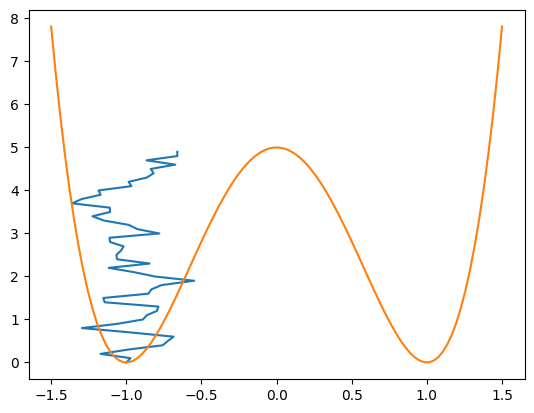

In [3]:
from path_sampling import make_double_well_potential, sample_sde


hyperparams={'dt': 0.01, 'num_steps': 50, 'num_training_steps' : 1000}


potential = make_double_well_potential(v=5.0)

def uref(x, t): 
    # potential = lambda x: jnp.sum(x**4 - 8 * x**2,axis=-1)
    return -jax.grad(potential)(x)

path, time = sample_sde(
    b=uref, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=jax.random.key(0), 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps'])

# visualize path
plt.plot(path,time*10)
# plot potential
x = np.linspace(-1.5, 1.5, 100)

plt.plot(x, potential(x[:, None]))

# Defining h

We now define `h`

In [6]:

# b \mapsto b + dbds
# Pseudo code:
# create `xs` of shape [batch_size, num_steps, ndims]
# calculate expectation of J
# initialize a neural net as function from R^ndims x R -> R^ndims
# fit weights of neural net according to the loss function
# calculate test loss
# return lambda x: b(x) + dbds(x)
from mclmc import refine_path
from path_sampling import E_J, find_dbds, make_h_loss


def update(b, J, I, dbds, hyperparams, key, schedule, i, A, rho = lambda key: jnp.zeros((ndims,))-1.):
    """
    b: drift term. A function from R^ndims x R -> R^ndims
    hyperparams: dictionary of hyperparameters
    key: random key for the model
    i: index for the current iteration (just for labelling plots)
    Returns:
        new_b: the updated drift term, which is a function from R^ndims x R -> R^ndims
    """

    

    new_s = schedule[i]
    old_s = schedule[i-1] if i>0 else 0.0
    ds = new_s - old_s

    # b = make_b(schedule[:i], uref, dbds)

    path_key, model_key, refine_key = jax.random.split(key, 3)

    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))
    

    # xs : [batch_size, num_steps, ndims]
    xs, times = jax.pmap(lambda key:sample_sde(
    b=b, 
    W = W,
    rho = rho,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, hyperparams['batch_size']))

    time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']
    
    print("old s", old_s)

    # path refinement
    # new_xs = jax.pmap(lambda key, p: refine_path(
    # x=p,
    # s=old_s,
    # J=J,
    # I=I,
    # time=time,
    # rng_key=key,
    # num_steps=1000
    # ))(jax.random.split(refine_key, hyperparams['batch_size']), xs)[:,:, None]

    # print(E_J(xs, None), "ej x")
    # print(E_J(new_xs, None), "ej new x")
    # print(times)

    # for path in xs:
    #     plt.plot(path,(time/hyperparams['dt'])/10, label='old')

    # plt.plot(xs[0],(time/hyperparams['dt'])/10, label='old')
    # for path in new_xs:
    #     plt.plot(path,(time/hyperparams['dt'])/5, label=f'annealed')
    # plt.plot(new_xs[0],(time/hyperparams['dt'])/10, label=f'annealed{i}')

    # xs = jnp.concatenate((xs[:10, :, :], new_xs[:30, :, :]), axis=0)
    # xs = new_xs

    expectation_of_J = E_J(J, xs, None)

    dbds = find_dbds(
        dbds=dbds,
        J=J,
        s=new_s,
        b=b,
        # xs[:90, :, :],
        # times[:90, :],
        xs=xs,
        times=times,
        ys=None,
        num_training_steps=hyperparams['num_training_steps']
        )
    
    ### calculate test loss
    test_xs, test_times = jax.pmap(lambda key:sample_sde(
        b=b, 
        W = W,
        rho = rho,
        key=key, 
        dt=hyperparams['dt'], 
        num_steps=hyperparams['num_steps']))(jax.random.split(jax.random.key(500), hyperparams['batch_size']))

    print(f"Test loss is {make_h_loss(expectation_of_J=expectation_of_J, J=J, b=b, s=new_s)(dbds, test_xs, test_times, None)}")

    # new version
    # new+b = b + [dbds(x,t,s)*delta_s for s in ...]

    # print(ds, "ds")
    
    new_b =  lambda x, t: (b(x,t) + dbds(x,t, 0.0)*ds)

    # new_b =  lambda x, t: (b(x,t) + dbds(x,t, new_s))

    # new_b = make_b(schedule[:i+1], uref, dbds)

    plot = True
    if plot:

        x = jnp.expand_dims(jnp.linspace(-2, 2, 100), 1)
        # y = (x**4 - 8 * x**2)
        y = make_double_well_potential(v=5.0)(x)
        # y2 = jax.vmap(lambda k, t: new_b(k, t))(x, times[0])
        plt.ylim(0,15)
        if i==0: plt.plot(x, y)
        # plt.plot(x, y2/50)
        # print(y2)

        path, time = sample_sde(
            b=new_b, 
            W = W,
            rho = rho,
            key=key, 
            dt=hyperparams['dt'], 
            num_steps=hyperparams['num_steps'])
                
        # refined_path = refine_path(
        #     x=path,
        #     s=new_s,
        #     J=J,
        #     b=
        #     I=I,
        #     time=time,
        #     rng_key=jax.random.key(2),
        #     num_steps=10000
        #     )
        

        print("OM of path", I(path, time, uref))
        # print("OM of refined path", I(refined_path, time, uref))

        plt.plot(path,(time/hyperparams['dt'])/10, label=f"s: {new_s}")
        # plt.plot(refined_path,(time/hyperparams['dt'])/10, label=f'refined, s:{new_s}')
        # plt.savefig('potential_new.png')
        plt.legend()

    return new_b, A - ds*expectation_of_J


old s 0.0
Train loss: 55244.9609375
Test loss is 80513.5625
OM of path 80.975945
old s 0.1
Train loss: 26337.78515625
Test loss is 28935.66796875
OM of path 72.08916


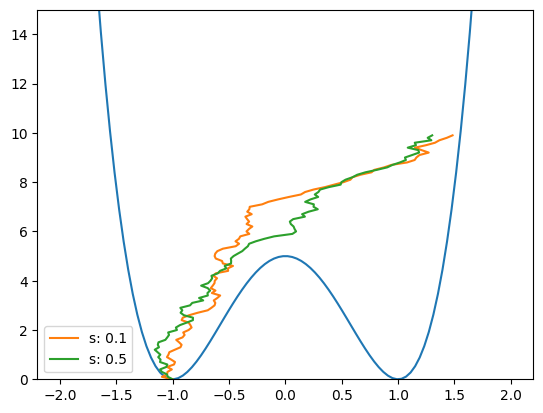

In [7]:
key = jax.random.key(0)
# b = uref # initialize b as uref
# schedule = [0.2,0.4,0.6,0.8,1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
schedule = [0.1, 0.5] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# schedule = [0.1,] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dbds = MLP([3,20,20,1], key=jax.random.key(0))



from path_sampling import dfdt, div_f


def I_UREF_TPS(x, time, uref):
    x = x.reshape((-1, ndims))
    dt = time[1]
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, uref)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - uref(xt, t)).dot(dxdt - uref(xt, t)) + 0.5*div_u)) (x, time, div_us, dxdts)
    return jnp.sum(out)        


b = lambda x, t: -jax.grad(make_double_well_potential(v=5.0))(x)
A = 0
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    b, A = update(
        b=b, # lambda x, t : jnp.array([0.0]),
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 5000, 'batch_size' :200},
        key=key,
        schedule=schedule,
        i=i,
        I=I_UREF_TPS,
        A=A
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

In [79]:
jnp.exp(A)

Array(1.3679167e-24, dtype=float32)

## SDE prior, brownian bridge posterior

old s 0.0
0.2 s
Train loss: 37369.6796875
Test loss is 79738.8828125
OM of path 88.4679
OM of refined path 60.090664
old s 0.2
0.4 s
Train loss: 25755.23046875
Test loss is 24977.86328125
OM of path 81.29489
OM of refined path 66.87681
old s 0.4
0.6 s
Train loss: 1261.3017578125
Test loss is 2392.020751953125
OM of path 69.50465
OM of refined path 68.32805
old s 0.6
0.8 s
Train loss: 1582.16552734375
Test loss is 2266.118408203125
OM of path 99.614006
OM of refined path 68.777466
old s 0.8
1.0 s
Train loss: 1811.9056396484375
Test loss is 2665.02880859375
OM of path 73.23742
OM of refined path 67.54542


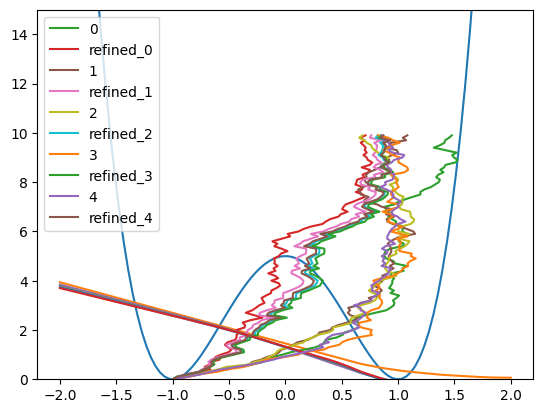

In [65]:
key = jax.random.key(0)
# b = uref # initialize b as uref
schedule = [0.2,0.4,0.6,0.8,1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dbds = MLP([3,20,20,1], key=jax.random.key(0))


b = lambda x,t: 0.0
A = 0
for i, s in enumerate(schedule):

    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    b, A = update(
        b=b, # lambda x, t : jnp.array([0.0]),
        J=lambda x,y: (1/0.1**2)*(x[-1,0]- 1)**2,
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :200},
        key=key,
        schedule=schedule,
        I=I,
        A=A,
        i=i,
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

# Brownian bridge TPS

old s 0.0
0.1 s
Train loss: 2950082.0
Test loss is 118752256.0
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
OM of path 68.40386
0.01
OM of refined path 43.537785
old s 0.1
0.2 s
Train loss: nan
Test loss is nan
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
OM of path nan
0.01
OM of refined path nan
old s 0.2
0.3 s
Train loss: nan
Test loss is nan
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
OM of path nan
0.01
OM of refined path nan
old s 0.3
0.4 s
Train loss: nan
Test loss is nan
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
OM of path nan
0.01
OM of refined path nan
old s 0.4
0.5 s
Train loss: nan
Test loss is nan
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
OM of path nan
0.01
OM of refined path nan
old s 0.5
0.6 s
Train loss: nan
Test loss is nan
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
OM of path nan
0.01
OM of refined path nan
old s 0.6
0.7 s
Train loss: nan
Test loss is nan
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
OM of path nan
0.01
OM of refined path nan
old s 0.7
0.8 s
Train loss: nan
Test loss is nan
0.

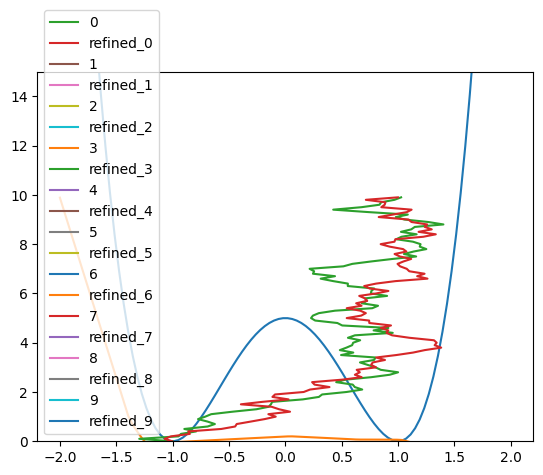

In [52]:
key = jax.random.key(0)
# b = uref # initialize b as uref
schedule = [0.1, 0.2] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dbds = MLP([3,20,20,1], key=jax.random.key(0))

hyperparams = {'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 10000, 'batch_size' :200}

brownian_bridge_drift = lambda x,t: (1 - x)/(1-t)

# potential = lambda x: jnp.sum(x**4 - 8 * x**2)
# force = jax.grad(lambda x: -jnp.sum(x**4 - 8 * x**2))


def I_brownian_bridge(x, time, b):
    x = x.reshape((-1, ndims))
    dt = hyperparams['dt']
    print(dt)
    dxdts = dfdt(x, dt)
    out = jax.vmap(lambda xt,t, dxdt : 0.25*dt*((dxdt).dot(dxdt)) )(x, time, dxdts)
    # div = jax.vmap(lambda xt,t, div_u, dxdt : div_u)(x, time, div_us, dxdts)
    # jax.debug.print("div {x}", x=jnp.sum(div))
    return jnp.sum(out)+((1/0.01)*jnp.linalg.norm(x[1,0] + 1)**2)+((1/0.01)*jnp.linalg.norm(x[-1,0] - 1)**2)


def J_brownian_bridge(x, y):

    x = x[:, 0]

    eps = 1. # hyperparams['dt']
    # laplacian of the potential
    pot = lambda x: (x**2 - 1)**2
    nabla_V = jax.grad(pot)
    laplacian_of_potential = jax.vmap(jax.grad(nabla_V))(x)


    # jax.debug.print("force x0 {x}", x=force(x[0]))
    return (1/(2*eps**2))*jnp.sum(jax.vmap(lambda xt, dv :  0.5*eps*(nabla_V(xt).dot(nabla_V(xt)) - eps*dv) )(x, laplacian_of_potential))



key = jax.random.key(0)
# b = uref # initialize b as uref
schedule = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dbds = MLP([3,20,20,1], key=jax.random.key(0))

rho = lambda key: jnp.zeros((ndims,))-1.
W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))
 

b = brownian_bridge_drift
A = 0
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # xs, times = sample_sde(
    #     b=lambda x,t: (1 - x)/(1-t), 
    #     W = W,
    #     rho = rho,
    #     key=key, 
    #     dt=hyperparams['dt'], 
    #     num_steps=hyperparams['num_steps'])
    
    # plt.plot(xs[:,0],times)

    # raise Exception

    # update b -> b + dbds
    b, A = update(
        b=b, # lambda x, t : jnp.array([0.0]),
        J=J_brownian_bridge,
        I=I_brownian_bridge,
        dbds=dbds,
        hyperparams=hyperparams,
        key=key,
        schedule=schedule,
        i=i,
        A=A
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

In [110]:
# def new_b(x, t): 
#     # assert x.shape[0] == ndims
#     return -jax.grad(lambda x: (x**4 - 8 * x**2))(x)

hyperparams={'dt': 0.001, 'num_steps': 200, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']


path_key = jax.random.key(1)
xs, times = jax.pmap(lambda key:sample_sde(
    b=uref, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))


def I_exp(x, time, b):
    x = x.reshape((-1, ndims))
    dt = hyperparams['dt']
    print(dt)
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, b)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - b(xt, t)).dot(dxdt - b(xt, t)) + 0.5*div_u) )(x, time, div_us, dxdts)
    # div = jax.vmap(lambda xt,t, div_u, dxdt : div_u)(x, time, div_us, dxdts)
    # jax.debug.print("div {x}", x=jnp.sum(div))
    return jnp.sum(out)


# use mcmc with the onsager machlup functional to correct samples

def refine_path_exp(x, s, time, rng_key, num_steps):
    initial_position = x.reshape(x.shape[0]*x.shape[1])

    # logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)-I_exp(x, time, lambda k, t: uref(k,t)) 
    logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)-I_exp(x, time, uref) - s*J(x.reshape((-1, ndims)), None)

    # logdensity_fn = lambda x: I(x, time, uref) 

    samples, _, params, chain_key = run_mclmc(
        logdensity_fn=logdensity_fn,
        num_steps=num_steps,
        initial_position=initial_position,
        key=rng_key,
        transform=lambda state, info: state.position
    )

    return samples[-1]




samples = refine_path_exp(
    x=xs[0],
    s=0.0,
    time=time,
    rng_key=jax.random.key(0),
    num_steps=100000
)



0.001
0.001
0.001
0.001
0.001
0.001
0.001


(200,)


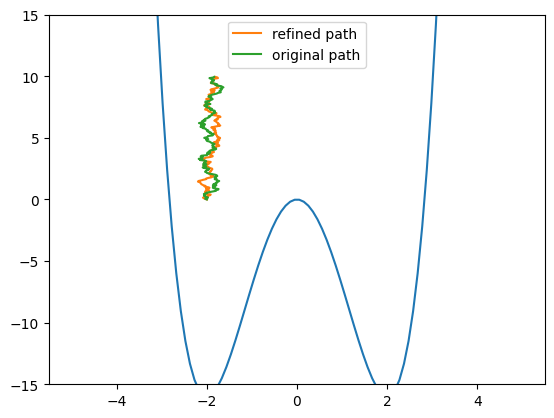

In [111]:
# plot samples[-1]
print(samples.shape)
# plt.plot(samples[0, :])
# hyperparams['dt']

# (time/hyperparams['dt']) / 5
# time

x = jnp.expand_dims(jnp.linspace(-5, 5, 100), 1)
y = (x**4 - 8 * x**2)
plt.ylim(-15,15)
plt.plot(x, y)
plt.plot(samples[:],(time/hyperparams['dt'])/20, label='refined path')
plt.plot(xs[0],(time/hyperparams['dt'])/20, label='original path')
plt.legend()

In [40]:
I_exp(samples, time, uref)
# samples.shape

0.001


Array(116.70465, dtype=float32)

## Brownian sanity check

In [50]:
# def new_b(x, t): 
#     # assert x.shape[0] == ndims
#     return -jax.grad(lambda x: (x**4 - 8 * x**2))(x)

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']


path_key = jax.random.key(0)
xs_true, times = jax.pmap(lambda key:sample_sde(
    b=lambda x,t: (1- x)/(1-t),
    W = lambda _, key: jax.random.normal(key, shape=(ndims,)),
    # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 100))

xs, times = jax.pmap(lambda key:sample_sde(
    b=lambda x,t: 0.0,
    W = lambda _, key: jax.random.normal(key, shape=(ndims,)),
    # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))


def J_exp(x,y):
    """
    x: path of the SDE, array of shape [num_steps, ndims]
    y: observation, here ignored, so assume it's `None`

    Returns:
        a scalar value representing the cost of the path
    """

    sigma = 0.1
    return (1/sigma**2)*(x[-1,0]- 1)**2

def I_exp(x, time, b):
    x = x.reshape((-1, ndims))
    dt = hyperparams['dt']
    print(dt)
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, b)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - b(xt, t)).dot(dxdt - b(xt, t)) + 0.5*div_u) )(x, time, div_us, dxdts)
    # div = jax.vmap(lambda xt,t, div_u, dxdt : div_u)(x, time, div_us, dxdts)
    # jax.debug.print("div {x}", x=jnp.sum(div))
    return jnp.sum(out)


# use mcmc with the onsager machlup functional to correct samples

def refine_path_exp(x, s, time, rng_key, num_steps):
    initial_position = x.reshape(x.shape[0]*x.shape[1])

    # logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)-I_exp(x, time, lambda k, t: uref(k,t)) 
    logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-1, scale=0.01)-I_exp(x, time, uref) - s*J_exp(x.reshape((-1, ndims)), None)

    # logdensity_fn = lambda x: I(x, time, uref) 

    samples, _, params, chain_key = run_mclmc(
        logdensity_fn=logdensity_fn,
        num_steps=num_steps,
        initial_position=initial_position,
        key=rng_key,
        transform=lambda state, info: state.position
    )

    return samples[-1]




samples = refine_path_exp(
    x=xs[0],
    s=1.0,
    time=time,
    rng_key=jax.random.key(0),
    num_steps=10000
)

0.01
0.01
0.01
0.01
0.01
0.01
0.01


# Brownian bridge TPS

In [89]:
# def new_b(x, t): 
#     # assert x.shape[0] == ndims
#     return -jax.grad(lambda x: (x**4 - 8 * x**2))(x)

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']


path_key = jax.random.key(0)
# xs_true, times = jax.pmap(lambda key:sample_sde(
#     b=lambda x,t: (1- x)/(1-t),
#     W = lambda _, key: jax.random.normal(key, shape=(ndims,)),
#     # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
#     rho = lambda key: jnp.zeros((ndims,))-1.,
#     key=key, 
#     dt=hyperparams['dt'], 
#     num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 100))

xs, times = jax.pmap(lambda key:sample_sde(
    b=lambda x,t: 0.0,
    W = lambda _, key: jax.random.normal(key, shape=(ndims,)),
    # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))


# nabla_V = lambda y: jax.grad(lambda x: potential(x))(y)[0]

def J_exp(x,y):

    x = x[:, 0]
    # print("x", x.shape)

    eps = 1. # hyperparams['dt']
    # laplacian of the potential
    pot = lambda x: (x**2 - 1)**2
    nabla_V = jax.grad(pot)
    laplacian_of_potential = jax.vmap(jax.grad(nabla_V))(x)


    # jax.debug.print("force x0 {x}", x=force(x[0]))
    return (1/(2*eps**2))*jnp.sum(jax.vmap(lambda xt, dv :  0.5*eps*(nabla_V(xt).dot(nabla_V(xt)) - eps*dv) )(x, laplacian_of_potential))
                                                                                #   ))(x, dVs))

def I_exp(x, time, b):
    x = x.reshape((-1, ndims))
    dt = hyperparams['dt']
    print(dt)
    dxdts = dfdt(x, dt)
    out = jax.vmap(lambda xt,t, dxdt : 0.25*dt*((dxdt).dot(dxdt)) )(x, time, dxdts)
    # div = jax.vmap(lambda xt,t, div_u, dxdt : div_u)(x, time, div_us, dxdts)
    # jax.debug.print("div {x}", x=jnp.sum(div))
    return jnp.sum(out)+((1/0.01)*jnp.linalg.norm(x[1,0] + 1)**2)+((1/0.01)*jnp.linalg.norm(x[-1,0] - 1)**2)


# use mcmc with the onsager machlup functional to correct samples

def refine_path_exp(x, s, time, rng_key, num_steps):
    initial_position = x.reshape(x.shape[0]*x.shape[1])

    # logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)-I_exp(x, time, lambda k, t: uref(k,t)) 
    logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-1, scale=0.01)-I_exp(x, time, uref) - s*J_exp(x.reshape((-1, ndims)), None)

    # logdensity_fn = lambda x: I(x, time, uref) 

    samples, _, params, chain_key = run_mclmc(
        logdensity_fn=logdensity_fn,
        num_steps=num_steps,
        initial_position=initial_position,
        key=rng_key,
        transform=lambda state, info: state.position
    )

    return samples[-1]




samples = refine_path_exp(
    x=xs[0],
    s=1.0,
    time=time,
    rng_key=jax.random.key(0),
    num_steps=10000
)

0.01
0.01
0.01
0.01
0.01
0.01
0.01


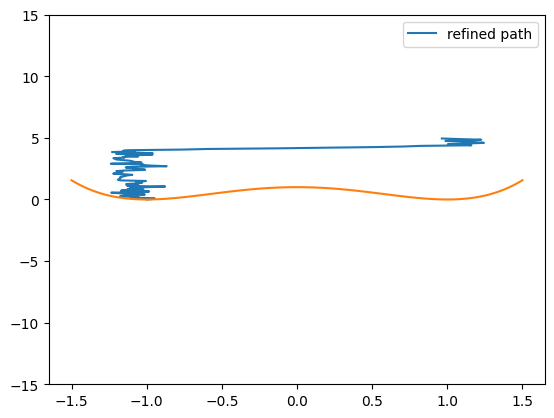

In [91]:
import matplotlib.pyplot as plt
plt.ylim(-15,15)
# plt.plot(xs[0,:,0],(time/hyperparams['dt'])/20, label='original path')
plt.plot(samples,(time/hyperparams['dt'])/20, label='refined path')
x = np.linspace(-1.5, 1.5, 100)

plt.plot(x, make_double_well_potential(v=1.0)(x[:, None]))
plt.legend()

# xs

## SPDE approach

In [228]:
hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']


force = jax.grad(lambda x: -jnp.sum(x**4 - 8 * x**2))


def numerical_laplacian(arr, dt):

    arr = jnp.concatenate([jnp.array([arr[0]]), arr, jnp.array([arr[-1]])])
    fst_diff = (arr[1:] - arr[:-1])
    snd_diff = (fst_diff[1:] - fst_diff[:-1])
    jax.debug.print("snd_diff {x}", x=snd_diff)
    return snd_diff

def spde_integrator(x, force, sigma=1, num_steps=10):
    ds = 0.01


    def step(x):

        # second_difference = (first_difference[:-1] - ) / hyperparams['dt']
        laplace_t_x = numerical_laplacian(x, dt=hyperparams['dt'])
        term2 = -jax.vmap(force)(x)*jax.vmap(jax.grad(force))(x)
        term3 = -(sigma**2)*jax.vmap(jax.grad(jax.grad(force)))(x)
        noise = jnp.sqrt(2)*jax.random.normal(key, shape=x.shape)

        return x + ds*(1/(sigma**2))*(laplace_t_x + term2 + term3) + jnp.sqrt(ds)*noise
    
    for i in range(num_steps):
        x = step(x)
        # print(x.shape)

    return x

# spde_integrator(
#     x=jnp.array([1.,2.,1.,4.,5.,1.,1.]),
#     force=force,
#     ).shape



initial = jnp.linspace(-1,1, 100)
# initial


snd_diff [ 2.0202041e-02  0.0000000e+00 -1.1920929e-07  1.1920929e-07
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -1.1920929e-07  1.1920929e-07  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -1.1920929e-07  1.1920929e-07
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.1920929e-07
  2.3841858e-07 -2.3841858e-07  1.1920929e-07  0.0000000e+00
 -8.9406967e-08  1.4901161e-07 -1.1920929e-07  2.9802322e-08
  2.9802322e-08  0.0000000e+00 -2.9802322e-08 -2.9802322e-08
  1.1920929e-07 -1.4901161e-07  8.9406967e-08  0.0000000e+00
 -8.9406967e-08  1.4901161e-07 -1.1920929e-07  2.9802322e-08
  2.9802322e-08  0.0000000e+00 -2.9802322e-08 -2.9802322e-08
  1.1920929e-07 -1.4901161e-07  8.9406967e-08  0.0000000e+00
 -8.9406967e-08  5.9604645e-08  2.9802322e-08  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.1920929e-07
  1.1920929e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -1.1920929e-07  1.1920929e-07  0.0000000e+00
  0.0000000e+00

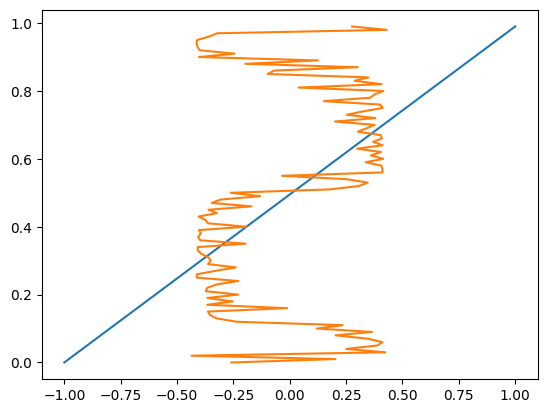

In [229]:
# plot initial
time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']
plt.plot(initial, time, label='initial')
x = spde_integrator(
    x=jnp.array(initial),
    force=force,
    )
# initial.shape
plt.plot(x, time, label='integrated')

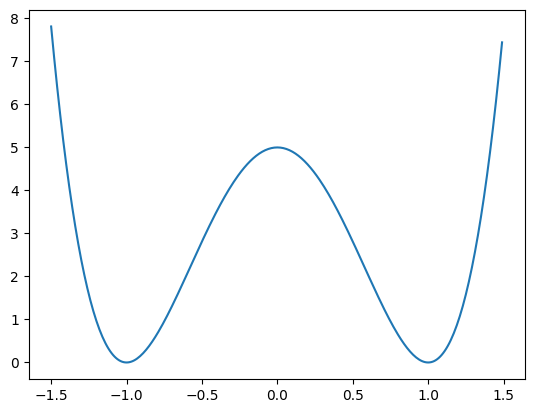

In [242]:
# plot (x^2 - 1)^2
inp = jnp.arange(start=-1.5, stop=1.5, step=0.01)
# inp
plt.plot(inp, 5*(inp**2 - 1)**2, label='potential')